In [16]:
import os
import requests
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

os.chdir('..')

In [9]:
from src.diffusion_from_scratch.diffussion import linear_beta_schedule
from src.diffusion_from_scratch.diffussion import q_sample

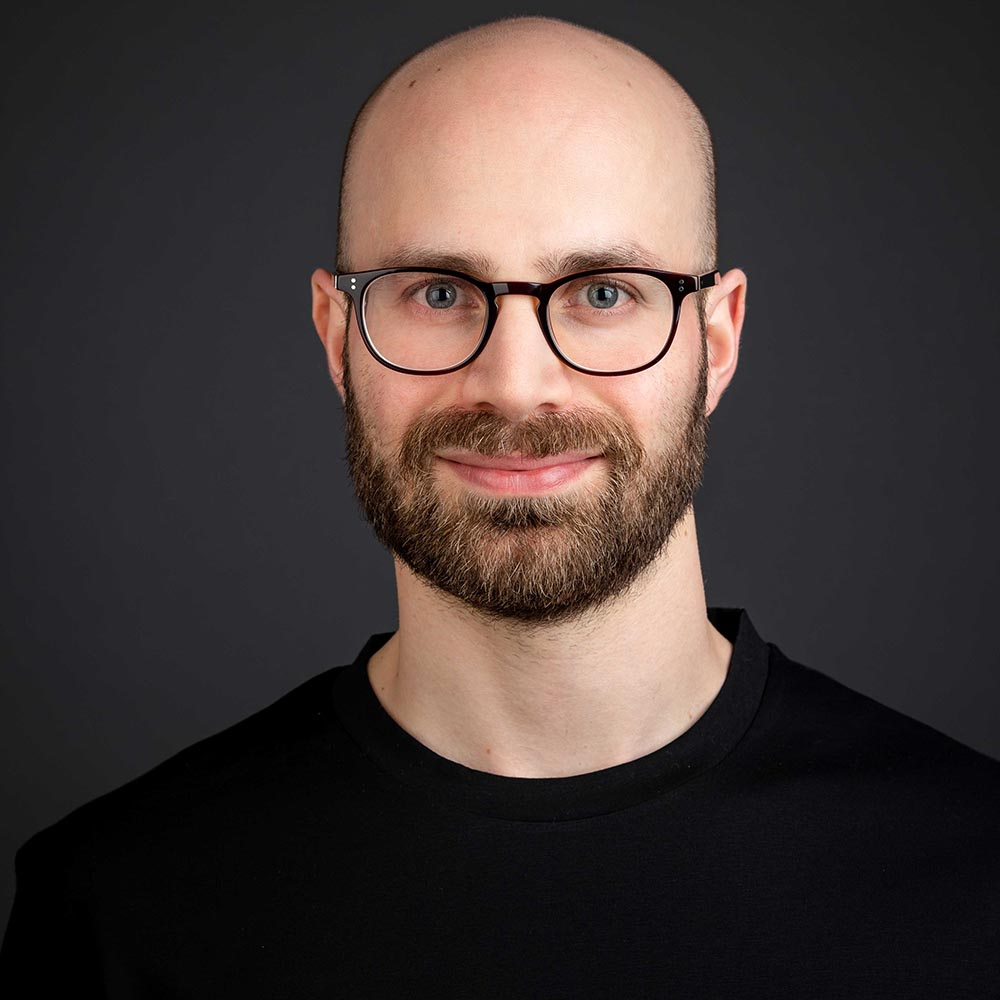

In [10]:
image_size = 128

# Load image
url = 'https://www.statworx.com/wp-content/uploads/2021/11/fabian-mueller.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [11]:
# Define a transformation pipeline that resizes the image to image_size x image_size,
# center and crops it, converts it to a tensor, and normaizes it to [0, 1] range by dividing by 255
# and finally nornalizes it to [-1, 1] range.
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

# Reserve transformation from [-1, 1] to PIL image
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

In [12]:
# Check the shapes after transformation
x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

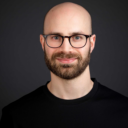

In [13]:
# Example after reserve transformation
reverse_transform(x_start.squeeze())

In [14]:
def get_noisy_image(x_start, t):
  """
  Returns the noisy image at time t.
  """
  # Sample noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

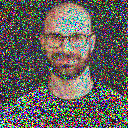

In [15]:
# Test for timestep t=40
t = torch.tensor([40])
get_noisy_image(x_start, t)

In [18]:
# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    """
    Plots a list of images for various time steps.
    """
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [20]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])